1\. **Color-coded scatter plot**

Produce a scatter plot from a dataset with two categories.

* Write a function that generates a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and standard deviation. Set different values of the mean and stardand deviation between the two samples.
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below:

In [ ]:
from IPython.display import Image
Image('two_categories_scatter_plot.png')

In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import scipy 

Text(0, 0.5, 'y')

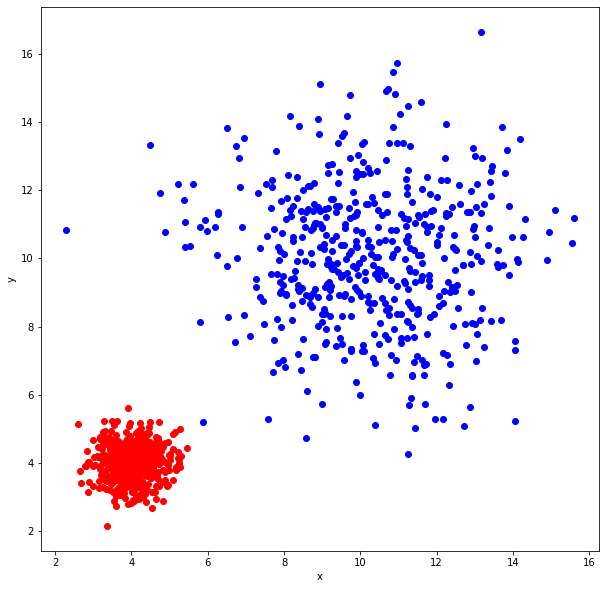

In [2]:
def generate_dataset(mean,std,l):    
    category=np.random.normal(mean,std,(l,2))
    return (category)

fig,ax=plt.subplots(figsize=(10,10))
c1=generate_dataset(4,0.5,500)
c2=generate_dataset(10,2,500)

ax.scatter(c1[:,0],c1[:,1],c='r')
ax.scatter(c2[:,0],c2[:,1],c='b')
ax.set_xlabel('x')
ax.set_ylabel('y')


2\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following pickle file:
```bash
wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/
```
* Inspect the dataset, you'll find two variables (features)
* Convert the content to a Pandas Dataframe
* Clean the sample by selecting the entries (rows) with the absolute values of the variable "residual" smaller than 2
* Plot a Seaborn jointplot of "residuals" versus "distances", and use seaborn to display a linear regression. 

Comment on the correlation between these variables.

* Create manually (without using seaborn) the profile histogram for the "distance" variable; choose an appropriate binning.
* Obtain 3 numpy arrays:
  * `x`, the array of bin centers of the profile histogram of the "distance" variable
  * `y`, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * `err_y`, the standard deviation of the of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

In [ ]:
!wget https://www.dropbox.com/s/3uqleyc3wyz52tr/residuals_261.pkl -P data/

In [36]:
infile = open('./data/residuals_261.pkl', 'rb')
new_dict = pickle.load(infile)
infile.close()

df = pd.DataFrame(new_dict.tolist())
df = df[abs(df['residuals'])<2]
df

,residuals,distances
0,1.100000,16.0
1,-1.950000,6.3
8,-0.042857,3.3
9,0.128571,5.3
10,0.085714,15.0
...,...,...
11126,-0.760000,14.4
11127,0.380000,7.5
11128,0.083333,1.7
11129,0.166667,19.1


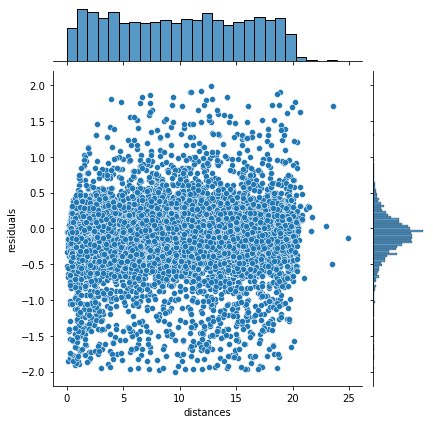

In [37]:
sns.jointplot(x = 'distances', y = 'residuals', data = df)

Text(0, 0.5, 'y')

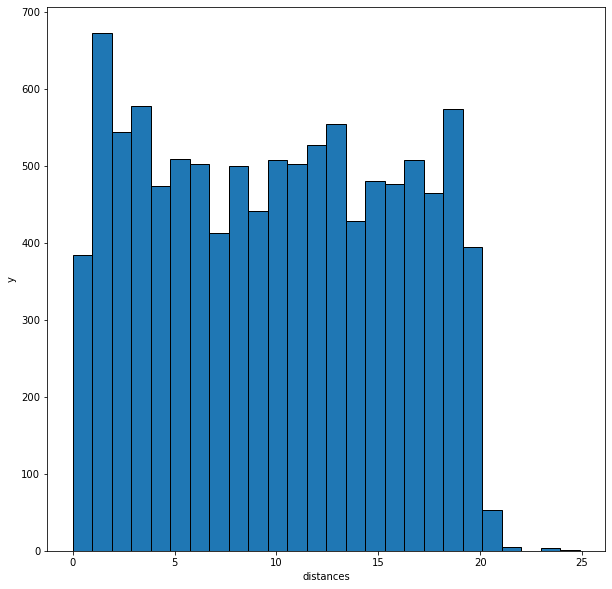

In [50]:
nbin = ( df['distances'].max() - df['distances'].min() )/(2*scipy.stats.iqr(df['distances'].values)/(len(df.index)**(1./3)))
fig,ax=plt.subplots(figsize=(10,10))
_, bins, _ = ax.hist(df['distances'].values,int(nbin), edgecolor = "black")
ax.set_xlabel('distances')
ax.set_ylabel('y')

In [51]:
x = []
y = []
err_y = []
for i in range(1,len(bins)):
    temp = df[(df['distances']>bins[i-1]) & (df['distances']<=bins[i])]['residuals'].values
    if(len(temp) > 0):
        x.append((bins[i]+bins[i-1])/2)
        y.append(np.mean(temp))
        err_y.append(np.std(temp))

x = np.array(x)
y = np.array(y)
err_y = np.array(err_y)

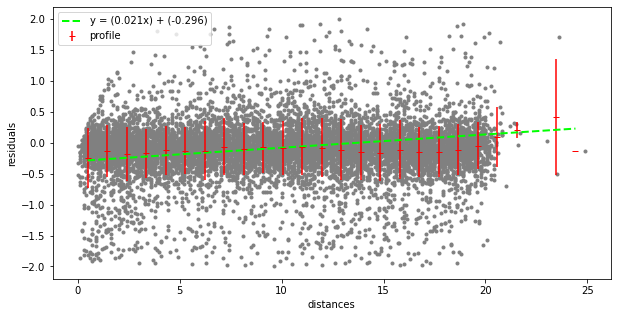

In [52]:
plt.subplots(figsize=(10,5))
plt.scatter(df['distances'], df['residuals'], marker='.', c='gray')
plt.errorbar(x, y, err_y,fmt='_', ecolor='r', color='r', label='profile')

# linear fit
pars, _ = np.polyfit(x, y, 1, w=err_y, cov='unscaled')
plt.plot(x, np.polyval(pars, x), '--',color='lime', lw=2, label = 'y = ({:.3f}x) + ({:.3f})'.format(pars[0],pars[1]))
plt.legend()
plt.xlabel('distances')
plt.ylabel('residuals')
plt.show()

3\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn):

* Fill a numpy array `x` of length N (with $N=\mathcal{O}(100)$) with a variable normally distributed, with a given mean and standard deviation
* Fill an histogram in pyplot taking proper care of the aesthetic:
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of y axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* For every element of `x`, create a gaussian with the mean corresponding to the element value and the standard deviation as a parameter that can be tuned. The standard deviation default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with `np.sum()`) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method. Superimpose the normalized sum of all gaussians to the first histogram.


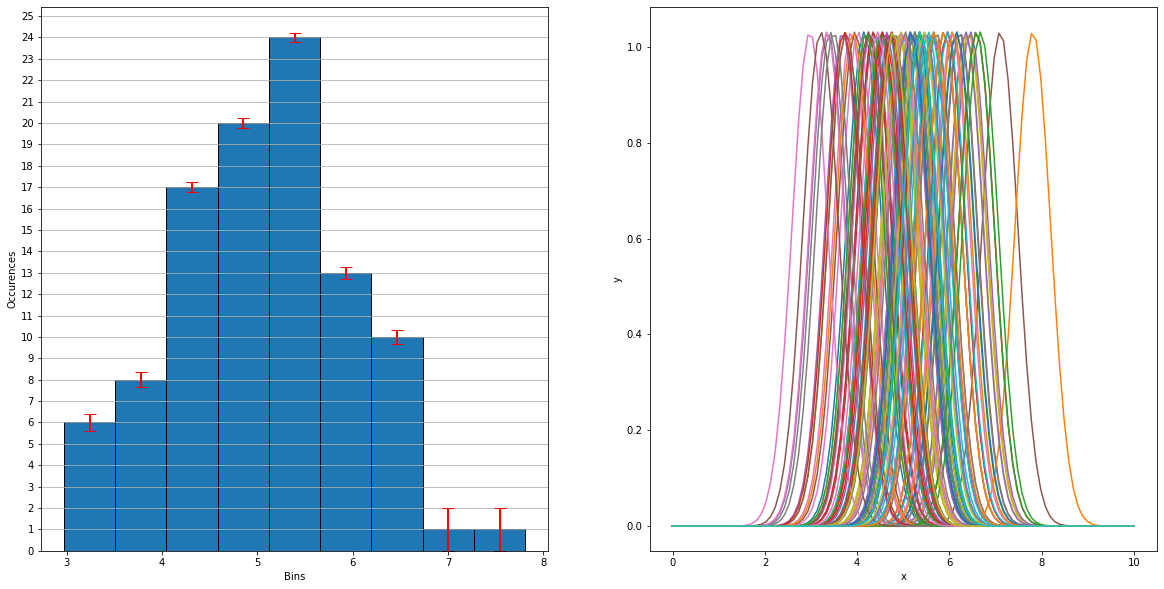

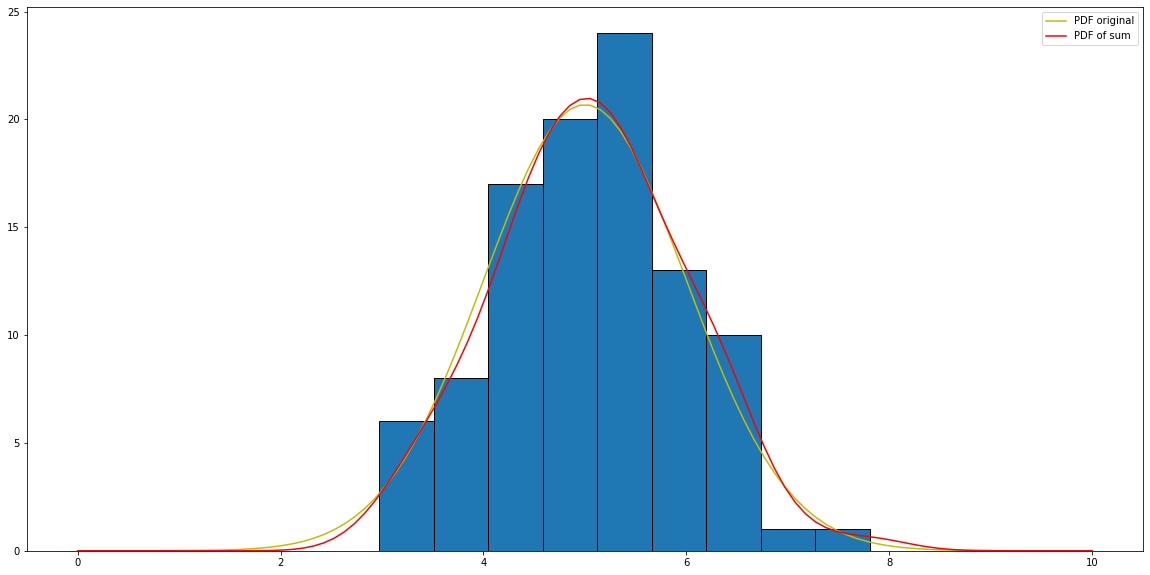

In [181]:
from matplotlib.ticker import MultipleLocator


mean = 5
std = 1
N = 100
x = np.random.normal(mean, std, N)

nbin = (x.max() - x.min())/(2*scipy.stats.iqr(x) / (len(x)**(1./3)))

fig, axs = plt.subplots(nrows=1, ncols= 2, figsize=(20,10))
y,bin_edges,_ = axs[0].hist(x,int(nbin),edgecolor = "black")
bin_centres = (bin_edges[:-1] + bin_edges[1:])/2.
err = 1/np.sqrt(y)
axs[0].errorbar(bin_centres, y, yerr=err, fmt='none', c='red', linewidth=2, capsize=6)
axs[0].set_xlabel('Bins')
axs[0].set_ylabel('Occurences')
axs[0].yaxis.grid()
axs[0].yaxis.set_major_locator(MultipleLocator(1))

std2 = 1.06 * np.std(x) * (len(x)**(-1./5))
pdf_sum = np.zeros((N,))
space = np.linspace(0, 10, N)
for mu in x:
    pdf = scipy.stats.norm.pdf(space, mu, std2)
    pdf_sum = pdf_sum + pdf
    axs[1].plot(space, pdf)

axs[1].set_xlabel('x')
axs[1].set_ylabel('y')

fig2,ax2 = plt.subplots(figsize = (20,10))
ax2.hist(x,int(nbin),edgecolor = "black")

hist_integral = scipy.integrate.trapz(y, bin_centres)

original_pdf = scipy.stats.norm.pdf(space, mean, std)
original_integral = scipy.integrate.trapz(original_pdf, space)
original_pdf = original_pdf/ original_integral*hist_integral
ax2.plot(space,original_pdf, c='y', label='PDF original')

pdf_sum_integral = scipy.integrate.trapz(pdf_sum, space)
pdf_sum = pdf_sum/ pdf_sum_integral*hist_integral
ax2.plot(space,pdf_sum, c='r', label='PDF of sum')

ax2.legend()